# Installing Libraries and dependencies

In [ ]:
import os
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete
  !pip install mujoco

try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco_py
  _mujoco_run_once = True

In [ ]:
### Installations for media_py at colab

!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.0 MB/s eta 0:00:00


In [ ]:
import gym
import numpy as np
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import time
import mediapy as media
import cv2

#Creating dataset using OpenAI Gym

In [ ]:
!cp '/content/drive/MyDrive/Sem 2/ell729/hopper-medium-expert-v2.pkl' .

In [ ]:
# Define environment
env = gym.make('Hopper-v2')
paths = pickle.load(open('hopper-medium-expert-v2.pkl', 'rb'))

In [ ]:
# Generate trajectories
H = 200
WINDOW = 10

dataset = []
for p in paths:
  path_length = len(p['rewards'])
  if path_length < H:
    p['observations'] = np.append(p['observations'], [p['next_observations'][-1] for _ in range(H-path_length)], axis=0)
    p['next_observations'] = np.append(p['next_observations'], [p['next_observations'][-1] for _ in range(H-path_length)], axis=0)
    p['rewards'] = np.append(p['rewards'], [0 for _ in range(H-path_length)])
    p['actions'] = np.append(p['actions'], [np.zeros(env.action_space.shape[0]) for _ in range(H-path_length)], axis=0)
    dataset.append(p)
    continue

  i = H
  while i <= path_length:
    t = {}
    t['observations'] = p['observations'][i-H:i]
    t['next_observations'] = p['next_observations'][i-H:i]
    t['rewards'] = p['rewards'][i-H:i]
    t['actions'] = p['actions'][i-H:i]
    dataset.append(t)
    i += WINDOW

In [ ]:
print('Number of trajectories: {}'.format(len(dataset)))

Number of trajectories: 138000


#Offline Training

In [ ]:
# Define environment
env = gym.make('Hopper-v2')

D = env.observation_space.shape[0] + env.action_space.shape[0]

# Define hyperparameters
K = 256
gamma = 0.99

np.random.seed(42)
theta = np.random.multivariate_normal(np.zeros(D), np.eye(D), size=K)

def phi_fn(s, a, theta):
    sa = np.append(s,a,axis=1)
    return np.tanh(theta @ sa.T)

In [ ]:
### Creating dataset_phi for offline training

dataset_phi_x = []
dataset_phi_y = []
gamma_vector = [gamma**h for h in range(H)]

for d in dataset:
  observations = d['observations']
  start_state = observations[0]
  actions = d['actions']

  x = np.concatenate([start_state, actions.reshape(-1)])
  dataset_phi_x.append(x)

  y_vector = np.sum(gamma_vector * phi_fn(observations, actions, theta), axis=1)
  dataset_phi_y.append(y_vector)

In [ ]:
psi = MLPRegressor(hidden_layer_sizes=K, activation='tanh', max_iter=100).fit(dataset_phi_x, dataset_phi_y)

In [ ]:
pickle.dump(psi, open('psi_function_tanh_200_100epoch.sav', 'wb'))

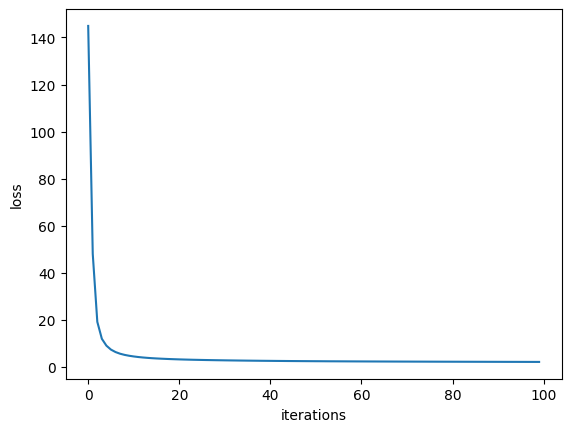

In [ ]:
plt.plot(range(len(psi.loss_curve_)), psi.loss_curve_)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss function over training iterations')
plt.show()

# Online Planning

In [ ]:
reward = SGDRegressor(alpha=0.01, fit_intercept=False) ### alpha: regularization

In [ ]:
batch_size = 1024
epochs = 100

for epoch in range(epochs):
  i = 0
  while i<len(dataset):
    dataset_w_x = []
    dataset_w_y = []
    j = 0
    while j<batch_size and (i+j)<len(dataset):
      d = dataset[i+j]
      observations = d['observations']
      actions = d['actions']
      sa = np.append(observations, actions, axis=1)
      x = np.tanh(sa @ theta.T)
      dataset_w_x.append(x)
      dataset_w_y.append(d['rewards'])
      j+=1

    i += j
    dataset_w_x = np.array(dataset_w_x).reshape(len(dataset_w_x)*H, K)
    dataset_w_y = np.array(dataset_w_y).reshape(-1)

    reward.partial_fit(dataset_w_x, dataset_w_y)

In [ ]:
pickle.dump(reward, open('reward.sav', 'wb'))

# Policy prediction

In [ ]:
def policy(state, env, psi, reward_regressor):
  N = 1000
  H_test = 10

  potential_actions = []
  state_representations = []

  for n in range(N):
    actions = []
    for h in range(H_test):
      action = env.action_space.sample()
      actions.append(action)
    potential_actions.append(actions[0])
    actions = np.array(actions).reshape(-1)
    state_representation = np.concatenate([state, actions])
    state_representations.append(state_representation)

  state_representations = np.array(state_representations)
  predicted_rewards = reward_regressor.predict(psi.predict(state_representations))
  best_n = np.argmax(predicted_rewards)
  return potential_actions[best_n]

In [ ]:
### Random Trajectory

# Define random policy
def random_policy(observation):
    return env.action_space.sample()

# L = Number of trajectories
L = 100

random_rewards = []
random_trajectories = []
for l in range(L):
  obs = env.reset(seed=l)
  random_trajectory = []
  total_reward_random = 0
  while True:
    action = random_policy(obs)
    obs_next, reward, done, info = env.step(action)
    random_trajectory.append((obs, action, reward, obs_next))
    total_reward_random += reward
    if done:
      break
    obs = obs_next
  random_rewards.append(total_reward_random)
  random_trajectories.append(random_trajectory)

In [ ]:
### Policy Oriented Trajectory

psi = pickle.load(open('psi_function_tanh_200_100epoch.sav', 'rb'))
reward_fn = pickle.load(open('reward.sav', 'rb'))

rewards = []
trajectories = []
all_frames = []
for l in range(L):
  obs = env.reset(seed=l)
  trajectory = []
  total_reward = 0
  prev_screen = env.render(mode='rgb_array')
  frames = [prev_screen]

  while True:
    action = policy(obs, env, psi, reward_fn)
    obs_next, reward, done, info = env.step(action)
    total_reward += reward
    trajectory.append((obs, action, reward, obs_next))
    screen = env.render(mode='rgb_array')
    frames.append(screen)
    if done:
      break
    obs = obs_next

  trajectories.append(trajectory)
  rewards.append(total_reward)
  all_frames.append(frames)

In [ ]:
trained_rewards = [reward for _,_,reward,_ in trajectories[0]]
random_rewards = [reward for _,_,reward,_ in random_trajectories[0]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


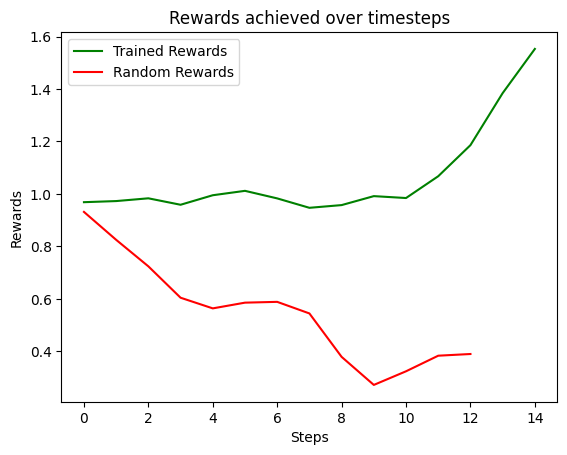

In [ ]:
plt.plot(range(len(trained_rewards)), trained_rewards, label='Trained Rewards', color='green')
plt.plot(range(len(random_rewards)), random_rewards, label='Random Rewards', color='red')
plt.xlabel('Steps')
plt.ylabel('Rewards')
plt.title('Rewards achieved over timesteps')
plt.legend()
plt.show()

#Rendering

In [ ]:
framerate = 30

In [ ]:
### Saving the video of the simulation
out = cv2.VideoWriter('simulation.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (480,480))
for frame in frames:
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

In [ ]:
### Rendering the video
display = Display(visible=0, size=(400, 300))
display.start()

media.show_video(frames, fps=framerate)